<a href="https://colab.research.google.com/github/dmitrijs-c/Neuromatch/blob/master/Neuromatch_Charcoal_Akitas_112_ADAM_team_%5BState_sequences_in_population_dynamics_across_cortical_aread%5D_Dmitrijs_07232020_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [3]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




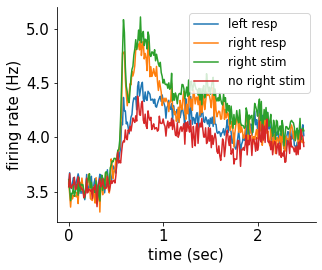

In [5]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [6]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

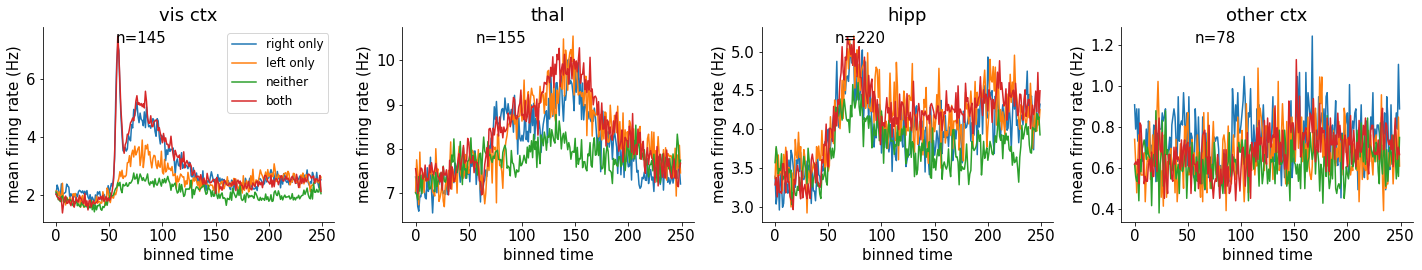

In [7]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


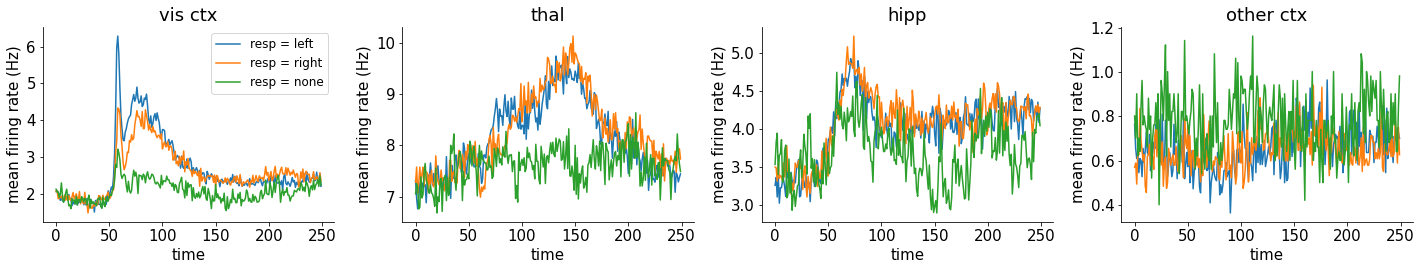

In [8]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [9]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

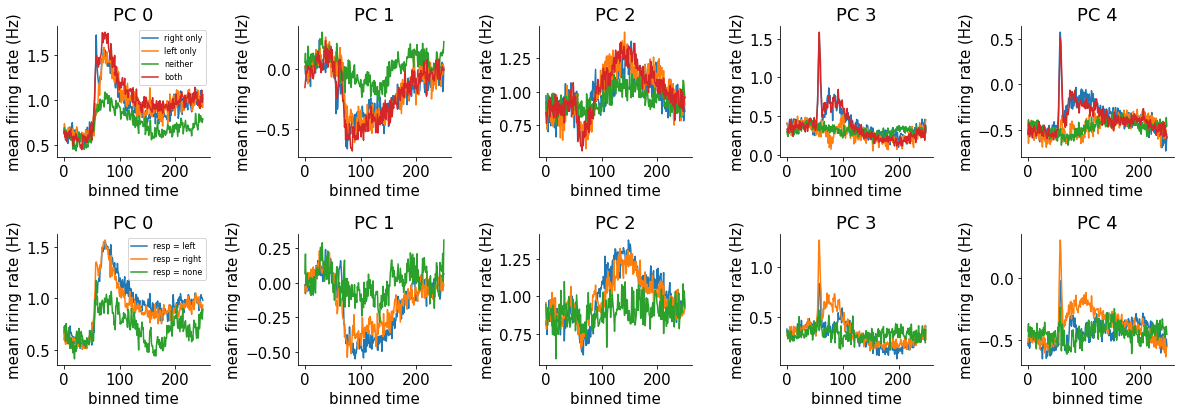

In [10]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

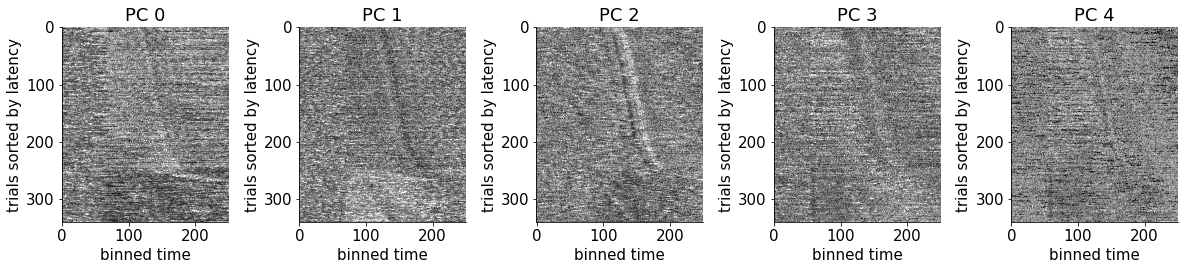

In [11]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

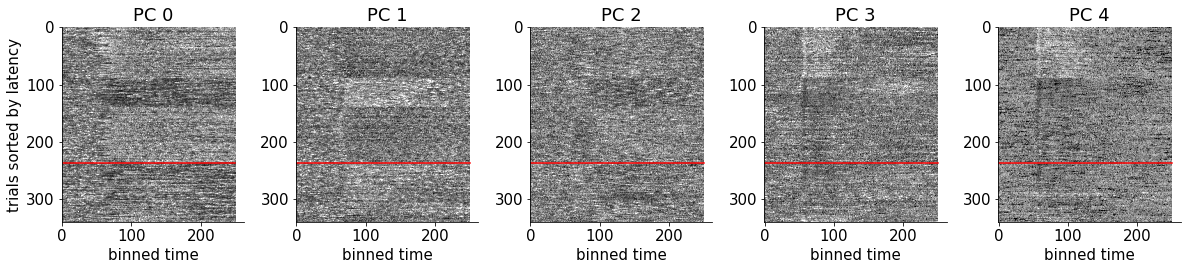

In [12]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


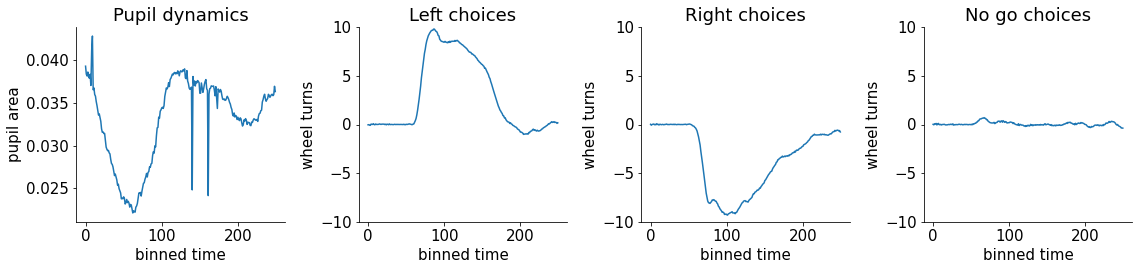

In [13]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


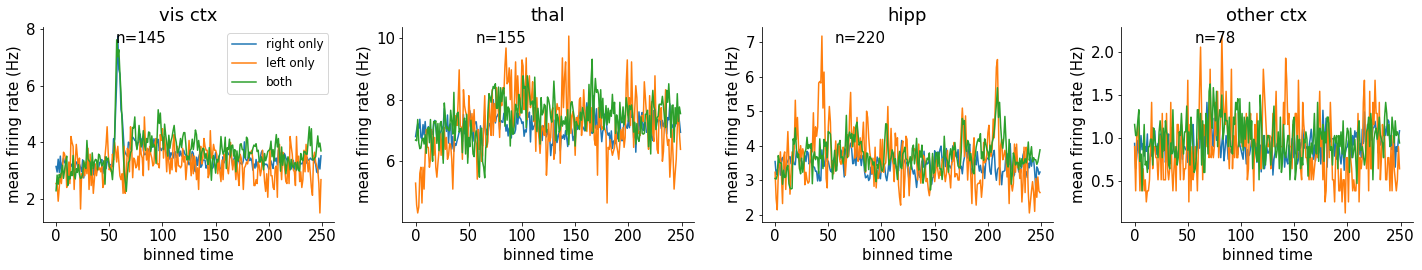

In [14]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')

In [15]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)

# Caleb Kemere's Poisson HMM
Adapted from iPython implementation available on [Github](https://github.com/slinderman/ssm/blob/master/notebooks/Poisson%20HMM%20Demo.ipynb) based on Kemere et al. 2019 paper "Detecting Neural-State Transitions Using Hidden Markov Models for Motor Cortical Prostheses"

## Install SSM

In [16]:
!pip install git+https://github.com/slinderman/ssm.git #works only when running from GitHub
!pip install numpy cython
!pip install -e .

  Cloning https://github.com/slinderman/ssm.git to /tmp/pip-req-build-k0_taa8i
  Running command git clone -q https://github.com/slinderman/ssm.git /tmp/pip-req-build-k0_taa8i
  Created wheel for ssm: filename=ssm-0.0.1-cp36-cp36m-linux_x86_64.whl size=382948 sha256=b0767597e2cf41a6ed99aba28215e642a93d8e3c68ec6dadb70e9b980d04da50
  Stored in directory: /tmp/pip-ephem-wheel-cache-p0unvup2/wheels/94/a8/2b/d4f99280918f82142dcf2bb94ad53873f4df57f5393aabfea3
Successfully built ssm
ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content


## Format the data for SSM


When calling SSM's fit function, the data is expected to be formatted as a **list datas** where **datas[i]** is a **2D array** of size **time_bins X observations**. Here, we'll reformat our data to match this. For us, this means that each entry of datas should be a **time_bins X neurons** (e.g. 250 x 698 for mouse 11).

In order for the following steps to make sense, we need to give more details about how the dat array is arranged. As mentioned, it is formatted as (neurons, trials, time). ??However, not every trial in the dataset is actually the same length -- this is because the length of the delay period is randomized, and it takes the monkey varying amounts of time to reach the target.

To acount for this, the FR array has been padded with NaNs so that all trials have the same length. This is very helpful, because it makes it easy to know which time bins correspond to each phase of the task. However, for our purposes, we don't want to include the NaNS when fitting our HMM (in fact, SSM will throw an error if we do). Instead, we will remove the columns of FR which contain NaNs, and create a list that matches the format above.??

In [16]:
#@title Define the trials used for training vs. testing
# train_idx: Indices of the trials we will use for training.
# test_idx: Indices of the trials we will use for testing.

train_idx = np.arange(0, dat['spks'].shape[1]*3/4, dtype=int)
test_idx = np.arange(dat['spks'].shape[1]*3/4+1, dat['spks'].shape[1], dtype=int)

dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.

In [17]:
def format_spikes(FR, idx):
    datas = []
    for i in idx: # iterating through trials
        spikes_cur = np.squeeze(FR[:,:,i]) # ignore the axis that quals to 1

        # remove columns which contain NaNs
        idx_keep = np.invert(np.any(np.isnan(spikes_cur), axis=0))
        spikes_cur = spikes_cur[:,idx_keep]

        # Transpose the data for passing to SSM fit function
        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(spikes_cur.T, dtype=int))
    return datas

left_move_idx = np.asarray(np. where(dat['response']==1))
no_move_idx = np.asarray(np.where(dat['response']==0))
right_move_idx = np.asarray(np.where(dat['response']==-1))

train_left_idx = list(np.intersect1d(left_move_idx, train_idx))
train_no_idx = list(np.intersect1d(no_move_idx, train_idx))
train_right_idx = list(np.intersect1d(right_move_idx, train_idx))

test_left_idx = list(np.intersect1d(left_move_idx, test_idx))
test_no_idx = list(np.intersect1d(no_move_idx, test_idx))
test_right_idx = list(np.intersect1d(right_move_idx, test_idx))

train_idx_combined = train_right_idx + train_no_idx + train_left_idx
test_idx_combined = test_right_idx + test_no_idx + test_left_idx


FR = np.rot90(dat['spks'],axes=(1, 2)) # grabbiong the spikes and rotating the array
# so that it's [neurons x time x trials]
train_datas = format_spikes(FR, train_idx_combined)
test_datas = format_spikes(FR, test_idx_combined)

## Fit a simple 3-state HMM

For this, we'll replicate Figure 3 in the paper. We'll fit a simple 5 state HMM with 1 baseline state, and 2-states each for reaches to the left and right (plan and move). We will assign our states as follows:

1. Baseline
2. Planning Right
3. Reaching Right
4. Planning Left
5. Reaching Left

In principles, we want our HMM to be a "left to right" HMM -- there is no way of moving from "Plan Left" to "Move Right" for example. Although SSM does not yet have the ability to specify this behavior (we are working on it!) we can get the same effect by carefully initializing the state transition matrix $A$. Our initialization will be as follows:

$A = \begin{bmatrix}
0.8 & 0.1 & 0 & 0.1 & 0 \\
0   & 0.9 & 0.1 & 0 & 0 \\
0   & 0   & 1   & 0 & 0 \\
0   & 0   & 0 & 0.9 & 0.1\\
0   & 0   & 0  &   0 & 1
\end{bmatrix}$

The syntax to create a standard HMM object using SSM is:  
`ssm.HMM(K, N, transitions=<transition_class>, observations=<observation_class>)`

We can manually set the state transition matrix using:  
`simple_hmm.transitions.log_Ps = logA`

Where $K$ is the number of discrete states, and $N$ is the dimensensionality of the observations. We'll use standard transitions and Poisson observations.
To fit our HMM to the training data, we call `HMM.fit(train_trials, masks=train_masks)`

In [71]:
#@title Simply testing array rotation
ssum = []
for j in range(len(dat['spks'][:,1,1])):
  for i in range(len(dat['spks'][77,1,:])):
    temp = sum(dat['spks'][j,i,:] - np.rot90(dat['spks'],axes=(1, 2))[j,:,i])
    ssum.append(temp)
    # print(temp)
print(sum(ssum))

0


In [72]:
num_states = 3
num_neurons = train_datas[0].shape[1]

# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0, 0, 0, 0]))
# Create our HMM
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="standard",
                     init_state_distn=init_dist)


# Manually initialize the means for each state
left_trials = FR[:,:,train_left_idx]
NoGo_trials = FR[:,:,train_no_idx]
right_trials = FR[:,:,train_right_idx]

#!!!need to provide time indices indicating when something is happening (e.g. moving, rotating, etc.)!!!
lambdas_move_left = np.nanmean(left_trials[:,:,:], axis=(1,2))
lambdas_NoGo = np.nanmean(NoGo_trials[:,:,:], axis=(1,2))
lambdas_move_right = np.nanmean(right_trials[:,:,:], axis=(1,2))

lambdas = np.vstack((lambdas_move_left,
                     lambdas_NoGo,
                     lambdas_move_right))

# Manually initialize the transition probabilities
A = np.array(
[[0.8, 0.1, 0],
[0, 0.9, 0.1],
[0, 0, 1]]
)

NameError: ignored

In [ ]:
simple_hmm.log_lambdas = np.log(lambdas + 1e-16)
simple_hmm.transitions.log_Ps = np.log(A + 1e-16)
lls = simple_hmm.fit(train_datas, method='em')


## Visualize the posterior likelihood over the states

In [ ]:
# get a random reach
test_trial_spikes = np.random.choice(train_datas)
posterior = simple_hmm.filter(test_trial_spikes)

In [ ]:
# plot posterior of states for a single test trial
plt.figure(figsize=(10, 4))
for i in range(num_states):
    plt.plot(posterior[:,i], label="State %d" % i)
plt.legend()